In [1]:
#import all helpful libraries
import scipy.io, scipy.optimize 
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import h5py
import pandas as pd
import Preprocessing as pp

# Import and Preperation of Data

In [2]:
data = {}
foldername = "../Data/Raw_Data/Messdaten_Test_ID_1/"
temp_data_folder = "../Data/Temp_Data"
mat_raw_files = ['n_soll.mat', 'P_el_rms.mat', 'P_th.mat', 't_el_rms.mat', 't_nsoll.mat', 't_th.mat']
for file in mat_raw_files:
    path = os.path.join(foldername, file)
    mat_file = scipy.io.loadmat(path)
    search = file[:-4]
    switcher = { #switcher is neccessary since files and matlab headers are not identical
        'n_soll': 'n_soll',
        'P_el_rms': 'P_elrms',
        'P_th': 'P_th',
        't_el_rms': 't_el_mean',
        't_nsoll': 't_2A_ela',
        't_th': 't_1B_th'
    }
    data[search] = mat_file[switcher.get(search)]

In [3]:
# edit and subsample data where neccessary
data_nsoll = data['n_soll'][0::1000]
data_p_elrms = data['P_el_rms'][0]
data_p_th = [x/3 for x in data['P_th'][0][0::10]]
data_t_nsoll = data['t_nsoll'].T[0::1000]
data_t_elrms = data['t_el_rms'][0]
data_t_th = data['t_th'][0][0::10]

### Saving files in TempData Folder

In [4]:
path = "../Data/Temp_Data/"
if not os.path.exists(path):
    os.mkdir(path)
    print('Creation of dircetory %s successful.' % path)

In [5]:
# np.savetxt(path + "n_soll.csv", data_nsoll, delimiter = ";")
# np.savetxt(path + "t_n_soll.csv", data_t_nsoll, delimiter = ";")
# np.savetxt(path + "p_elrms.csv", data_p_elrms, delimiter = ";")
# np.savetxt(path + "t_elrms.csv", data_t_elrms, delimiter = ";")
# np.savetxt(path + "p_th.csv", data_p_th, delimiter = ";")
# np.savetxt(path + "t_th.csv", data_t_th, delimiter = ";")

In [6]:
df_validation = pd.DataFrame()
df_validation['spinning'] = pp.downsampleData(data_t_nsoll, data_nsoll)[:,1]
df_validation['time'] = pp.downsampleData(data_t_nsoll, data_t_nsoll)[:,1]
df_validation['electric'] = pp.downsampleData(data_t_elrms, data_p_elrms)[:,1]
df_validation['thermal'] = pp.downsampleData(data_t_th, data_p_th)[:,1]

In [7]:
df_validation.to_csv(temp_data_folder + "experiment_1B.csv",
                    index = False, sep = "|", encoding='utf-8')

# Visualization of raw Data

The following figures show the development over time of thermal output (blue), electrical output (orange) or the 'Drehzahlsollwert" (green). The last figure shows a correlation between those measures.

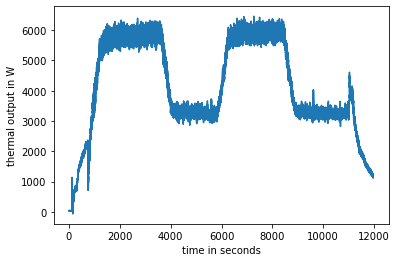

In [8]:
plt.plot(data_t_th, data_p_th)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

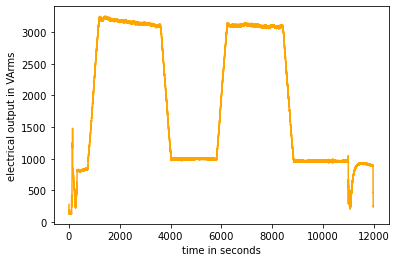

In [9]:
plt.plot(data_t_elrms, data_p_elrms, 'orange')
plt.xlabel("time in seconds")
plt.ylabel("electrical output in VArms")
plt.show()

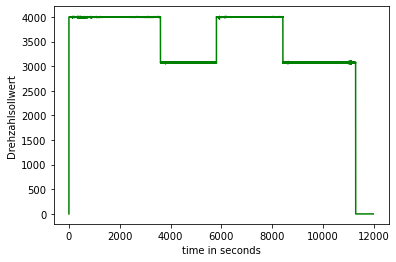

In [10]:
plt.plot(data_t_nsoll, data_nsoll, 'green')
plt.xlabel("time in seconds")
plt.ylabel("Drehzahlsollwert")
plt.show()

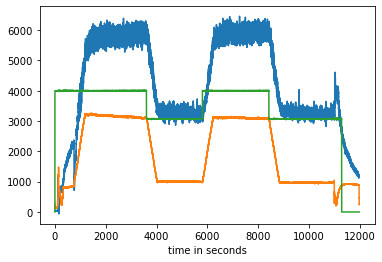

In [11]:
plt.plot(data_t_th, data_p_th)
plt.plot(data_t_elrms, data_p_elrms)
plt.plot(data_t_nsoll, data_nsoll)
plt.xlabel("time in seconds")
plt.show()

The experiment consists of 4 different phases, each with following durations:<br/>
0% -> 100%: 60 minutes (3600 secs -> change after 3605)<br/>
100% -> 30%: 36,75 minutes (2200 secs -> change after 5811)<br/>
30% -> 100%: 42 minutes (2500 secs -> change after 8429)<br/>
100% -> 30% 50 minutes (3000 secs -> change after 11294)

30% -> 0%: 11,5 minutes (690 secs -> ends at 11981)

In [12]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [13]:
def createTimeSubplots(time_data, values, color):
    fig,axs = plt.subplots(2, 3, figsize = (20,12))
    axs = axs.ravel()
    axs[0].plot(time_data, values, color)
    
    for t in range(len(time_splits)-1):
        data_part = values[(time_splits[t]+1)*5:time_splits[t+1]*5]
        time_part = time_data[(time_splits[t]+1)*5:time_splits[t+1]*5]
        rm = running_mean(data_part,300)
        axs[t+1].plot(time_part, data_part, color)
        axs[t+1].plot(time_part[299:], rm, color='yellow')
    
    plt.show()

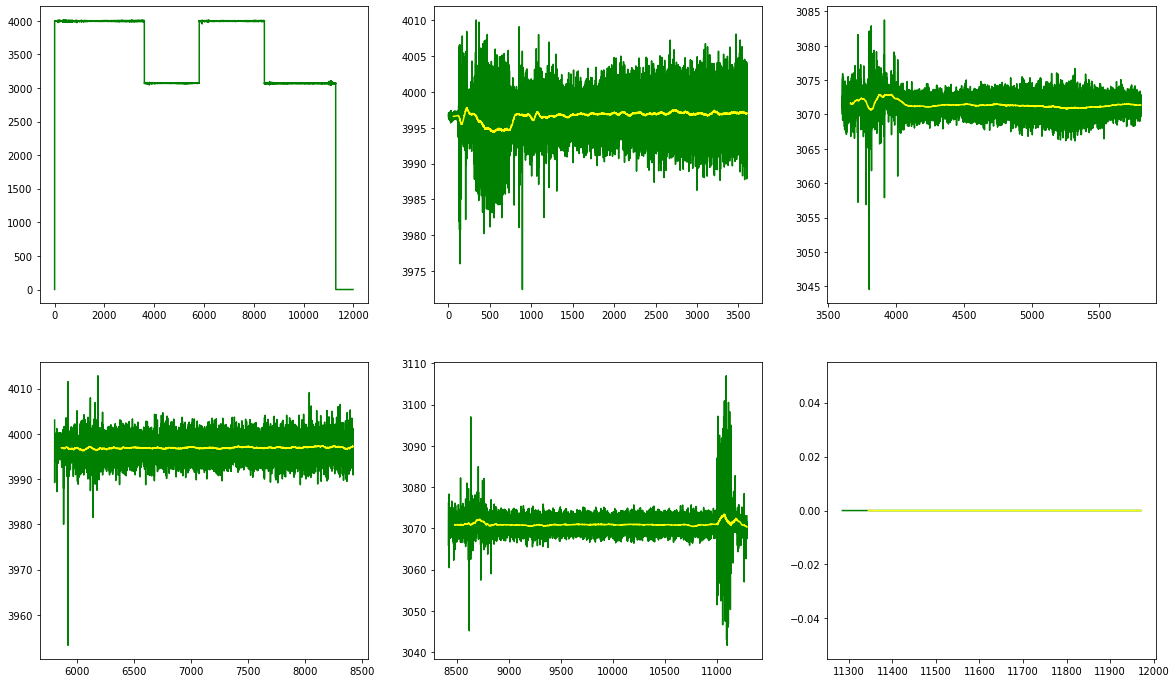

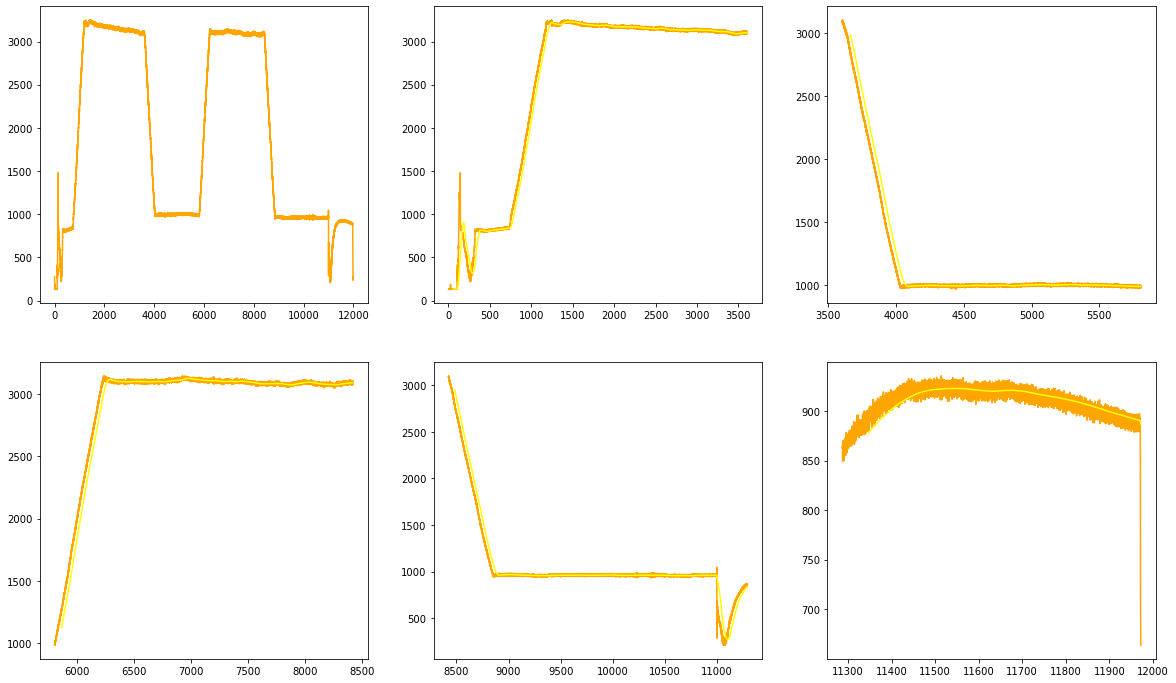

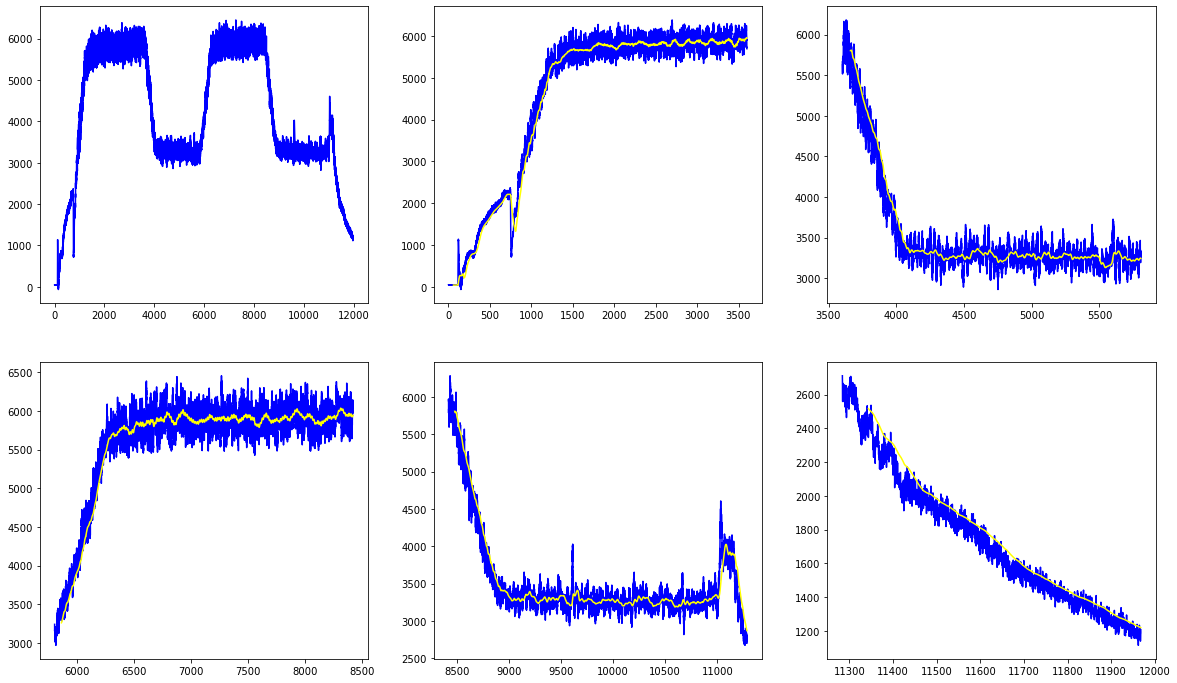

In [14]:
time_splits = [1, 3605, 5811, 8429, 11294, 11981]

createTimeSubplots(data_t_nsoll, data_nsoll, 'green')
createTimeSubplots(data_t_elrms, data_p_elrms, 'orange')
createTimeSubplots(data_t_th, data_p_th, 'blue')

# Comparison of data with theoretical baseline

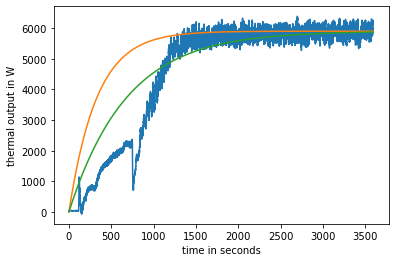

In [15]:
time_start = data_t_th[:18000]
k = 5900
plt.plot(time_start, data_p_th[:18000])
plt.plot(time_start, -k* np.exp((-1/330)*time_start) +k)
plt.plot(time_start, -k* np.exp((-1/680)*time_start) +k)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

In [16]:
para_fit = scipy.optimize.curve_fit(lambda t,k, tau: -k* np.exp((-1/tau)*t) +k, time_start, data_p_th[:18000])
k_best = para_fit[0][0]
tau_best = para_fit[0][1]
tau_best

1122.692846771155

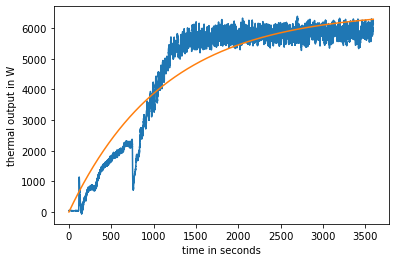

In [17]:
plt.plot(time_start, data_p_th[:18000])
plt.plot(time_start, -k_best* np.exp((-1/tau_best)*time_start) +k_best)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

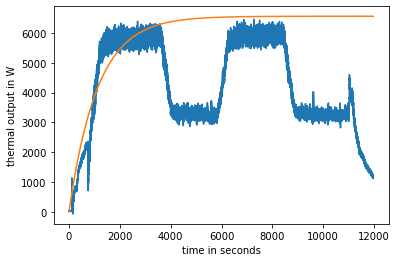

In [18]:
plt.plot(data_t_th, data_p_th)
plt.plot(data_t_th, -k_best* np.exp((-1/tau_best)*data_t_th) +k_best)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

# Comparison with pure ML model (testing on same Dataset)

In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from scipy import optimize
from mlinsights.mlmodel import PiecewiseRegressor


In [20]:
x_train, x_test, y_train, y_test = train_test_split(data_t_th, data_p_th, test_size = 0.80, random_state = 42)

In [21]:
model = DecisionTreeRegressor(min_samples_leaf=300)
model.fit(x_train.reshape(-1,1), y_train)

predictions = model.predict(data_t_th.reshape(-1,1))

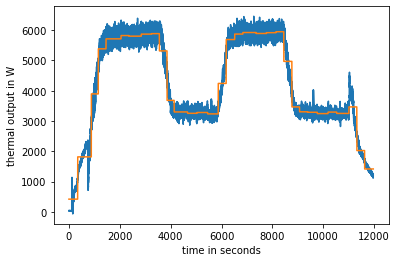

In [22]:
plt.plot(data_t_th, data_p_th)
plt.plot(data_t_th, predictions)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

In [23]:
#R^2
model.score(data_t_th.reshape(-1,1), data_p_th)

0.9694472301062669

In [24]:
mean_squared_error(data_p_th, predictions, squared = False)

273.3468848661749